In [2]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch
import matplotlib.pyplot as plt

In [3]:
# Load data (from zeke)

train = pd.read_csv('data/split/train_M.csv')
test = pd.read_csv('data/split/test_M.csv')

encoded_features = ['Level', 'problem','climber']
target = 'status'

X_train, X_test = train[encoded_features], test[encoded_features]
y_train, y_test = train[target], test[target]

In [4]:
# Data cleaning --> Features: climber, level, problem (from zeke)
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(encoded_features))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(encoded_features))

In [11]:
X_train_tensor = torch.tensor(X_train_encoded_df.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_encoded_df.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)

Epoch [10/50], Loss: 0.6105, Train Accuracy: 0.6784, Test Accuracy: 0.6764
Epoch [20/50], Loss: 0.6102, Train Accuracy: 0.6789, Test Accuracy: 0.6765
Epoch [30/50], Loss: 0.6101, Train Accuracy: 0.6789, Test Accuracy: 0.6767
Epoch [40/50], Loss: 0.6100, Train Accuracy: 0.6795, Test Accuracy: 0.6775
Epoch [50/50], Loss: 0.6099, Train Accuracy: 0.6796, Test Accuracy: 0.6778


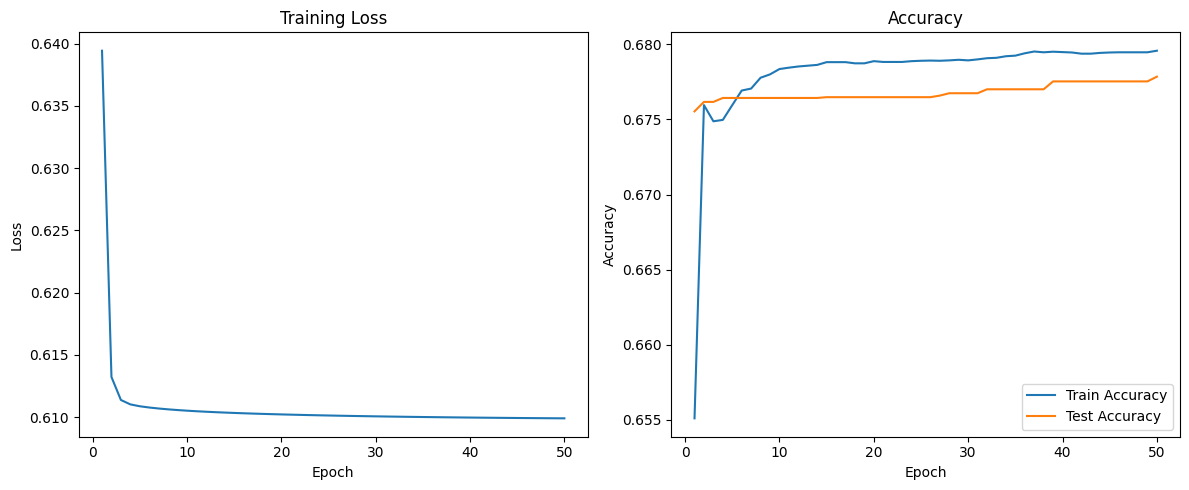

In [14]:
# Model
class LogRegModel(nn.Module):
    def __init__(self, df_dim):
        super().__init__()
        self.linear = nn.Linear(df_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x): #forward pass is linear into sigmoid
        out = self.linear(x)
        return self.sigmoid(out)

X_train, y_train = X_train_tensor, y_train_tensor
X_test, y_test = X_test_tensor, y_test_tensor

input_dim = X_train.shape[1] # shape of input
model = LogRegModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Training 
num_epochs = 50
batches = 32

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_train = 0
    for i in range(0, len(X_train), batches):
        batch_X = X_train[i:i+batches]
        batch_y = y_train[i:i+batches]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        correct_train += ((outputs > 0.5).float().squeeze() == batch_y).float().sum()
    
    train_loss = epoch_loss / (len(X_train) / batches)
    train_accuracy = correct_train / len(X_train)
    
    # Validation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_accuracy = ((test_outputs > 0.5).float().squeeze() == y_test).float().mean()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    if ((epoch + 1) % 10) == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Metrics 
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss, roc_auc_score, f1_score

In [21]:
y_pred = (model(X_test) > 0.5).float().squeeze().numpy()
y_pred_proba = model(X_test).squeeze().detach().numpy()

In [26]:
y_pred_proba

array([0.6483216 , 0.84637713, 0.6621843 , ..., 0.5317586 , 0.6658578 ,
       0.6447063 ], dtype=float32)

In [34]:
print("Accuracy:", accuracy_score(y_test, y_pred)) # 
print("Log loss:", log_loss(y_test, y_pred_proba))
print("Brier score loss:", brier_score_loss(y_test, y_pred_proba))
print(f"F1 Score: {f1_score(y_test, y_pred)}") #
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba)}")
print(f"predictions:  \n {pd.Series(y_pred).value_counts(normalize=True)}")
print(f"actual dist in test: \n {pd.Series(y_test).value_counts(normalize=True)}")

Accuracy: 0.6778495301097286
Log loss: 0.6101537962651408
Brier score loss: 0.21102912648929636
F1 Score: 0.7342112102572987
ROC AUC Score: 0.7142325042136216
predictions:  
 1.0    0.657479
0.0    0.342521
dtype: float64
actual dist in test: 
 1.0    0.554576
0.0    0.445424
dtype: float64
